# Cifar 10 

## Setup

### Imports

In [1]:
from functools import reduce

import numpy as np
import plotly.io as pio
from numpy import ndarray
import plotly.express as px
from numpy import array_split as split

from optimizers import Adam
from metrics import accuracy
from constants import MAX_NB_SAMPLES
from losses import BinaryCrossentropy
from cifar_10_dataset_loading import load_cifar_10
from layers import Convolutional, Linear, Relu, BatchNorm, Flatten, Softmax, MaxPool, Layer, LeakyRelu

In [2]:
pio.renderers.default = "jupyterlab+png"

### Data extraction

In [3]:
x_train, y_train, x_test, y_test = load_cifar_10()

In [4]:
classes = y_train.argmax(axis=1)

In [5]:
# Change range from [0, 255] to [-1, 1]
x_train = x_train / 255  
x_train.dtype

dtype('float64')

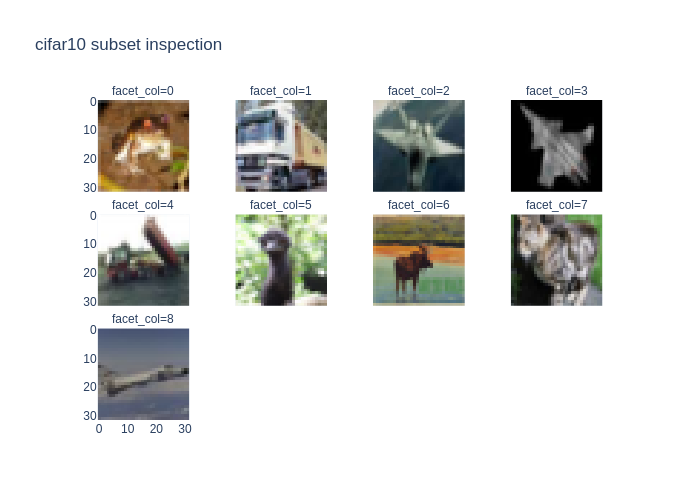

In [6]:
IMGS_IDX = [0, 1, 5673, 5494, 2, 55, 66, 776, 564]
x = x_train[IMGS_IDX]
y = y_train[IMGS_IDX]
px.imshow(x, facet_col=0, facet_col_wrap=4, title="cifar10 subset inspection")

In [7]:
NB_SAMPLES_PER_CLASS = 1000
NB_CLASSES = 10

class_masks = y_train.argmax(1, keepdims=True) == np.arange(NB_CLASSES)
take_first_n_of_class = lambda data, class_idx: data[class_masks[:, class_idx]][:NB_SAMPLES_PER_CLASS]
take_first_n_of_each_class = lambda data: np.concatenate([take_first_n_of_class(data, class_idx) for class_idx in range(NB_CLASSES)], axis=0)
x_train_subset = take_first_n_of_each_class(x_train)
y_train_subset = take_first_n_of_each_class(y_train)
x_train_subset.shape

(10000, 32, 32, 3)

## Fitting cifar10

### Model declaration

In [8]:
def create_nn() -> list[Layer]:
    return [
        Convolutional((10, 7, 7, 3)),
        BatchNorm(),
        Relu(),
        MaxPool((2, 2)),
        Flatten(),
        Linear(1690, 300),
        LeakyRelu(),
        Linear(300, y.shape[1]),
        Softmax(),
    ]

### Optimizer

In [9]:
def create_optimizer(nn:list[Layer]) -> Adam:
    return Adam(
        nn,
        x_train,
        y_train,
        BinaryCrossentropy(),
        starting_lr=0.015,
        lr_decay=0.0001,
        momentum_weight=0.8,
        ada_grad_weight=0.999,
        l2_weight=0.0,
    )

In [10]:
NB_TEST_BATCHES = int(np.ceil(len(x_test) / MAX_NB_SAMPLES))
loss = BinaryCrossentropy()

def test_accuracy(metric_line:dict, nn:list[Layer], **_) -> dict:
    y_test_pred = []
    for x_test_subset in split(x_test, NB_TEST_BATCHES):
        y_test_pred.append(reduce(lambda x, l: l.forward(x), nn, x_test_subset))
    y_test_pred = np.concatenate(y_test_pred)
    metric_line["test_accuracy"] =  np.mean(y_test_pred.argmax(1) == y_test.argmax(1))
    metric_line["test_loss"] = loss.forward(y_test_pred, y_test)
    return metric_line


### Training

In [11]:
nn = create_nn()
first_optimizer = create_optimizer(nn)

In [12]:
bad_training_stats = (
    first_optimizer
    .optimize_nn(
        epochs=35,
        batch_size=500,
        metrics=[accuracy, test_accuracy],
        plt_x="epoch",
        plt_ys=[
            "loss",
            "accuracy",
            "test_accuracy",
            "test_loss",
            "learning_rate",
        ],
        height=600,
    )
)

In [57]:
test_accuracy({}, nn)

{'test_accuracy': np.float64(0.6157),
 'test_loss': np.float64(0.19704411015083267)}

: 

: 

### Inspecting the trained model

In [48]:
TARGET_IMG = 30
px.imshow(x_train[TARGET_IMG])

: 

: 

In [49]:
imgs = x_train[:1000]
convs =  reduce(lambda x, l: l.forward(x), nn[:4], imgs) #nn[1].forward(nn[0].forward(img))
convs.shape
px.imshow(convs[TARGET_IMG], facet_col=2, facet_col_wrap=10)

: 

: 

In [50]:
convs.sum(axis=(0, 1, 2))

array([ 7719.74183977,  8931.58709477, 10115.75223513,  9194.23981924,
        8602.83988914,  7674.09249867,  4996.55641602, 10728.88280182,
       10886.05589166,  5669.60871381])

: 

: 

In [51]:
activations = reduce(lambda x, l: l.forward(x), nn[:7], imgs) #nn[1].forward(nn[0].forward(img))
activations.sum(axis=(0))

array([-8.60164992e+01, -1.18365224e+02, -2.32756473e+01, -6.25690387e+01,
       -2.28385667e+00, -2.81551023e+01, -1.15327951e+02, -7.76404920e+01,
       -9.07740285e+01, -2.05771979e+01, -3.38352490e+01, -9.07732004e+01,
       -9.48983579e+01, -1.94305021e+01,  2.07848614e+02, -7.46897649e+01,
        3.33579168e+02, -2.35657362e+01, -1.34667598e+02, -3.40132722e+01,
       -1.31026879e+02, -2.31315062e+01, -5.28386016e+01, -3.80135423e+01,
       -7.09538485e+01, -2.25460797e+01, -1.26517255e+02, -1.13663198e+02,
       -6.58836027e+01,  5.50391863e+01, -5.52291037e+01, -2.78577127e+01,
       -2.67129279e+01, -6.63689766e+01, -5.41602931e+01, -1.71797327e+01,
       -1.30976866e+02, -1.80078864e+02, -2.19202188e+01, -3.62954397e+01,
       -2.20648117e+01, -2.25367607e+01, -3.98178803e+01, -2.92110303e+01,
       -4.26180175e+01, -1.03067172e+02, -2.24610579e+01, -6.10107673e+01,
       -4.07890550e+01,  6.64278020e+01, -3.35255030e+01,  3.71562275e+02,
        3.15453257e+03,  

: 

: 

In [52]:
convs[[250]].shape

(1, 13, 13, 10)

: 

: 

In [53]:
def min_max_normalize(arr:np.ndarray, axis:tuple) -> np.ndarray:
    return (arr - arr.min(axis, keepdims=True)) / (arr.max(axis, keepdims=True) - arr.min(axis, keepdims=True))

MIN = nn[0].kernels.min()
MAX = nn[0].kernels.max()
normed_kernels = (nn[0].kernels - MIN) / (MAX - MIN)
normed_kernels.shape

px.imshow(normed_kernels, facet_col=0, facet_col_wrap=10)

: 

: 

In [54]:
nn[0].biases

array([[[[-1.10414266e-11, -3.70473200e-11,  3.55217559e-11,
           6.16767165e-11, -2.76272697e-11,  5.34983152e-12,
           1.37586063e-11, -1.21864915e-11, -2.56220143e-11,
           4.92803367e-11]]]])

: 

: 

In [55]:
nn[1].gamma

array([[[[0.20932831, 0.23406881, 0.1505719 , 0.19395444, 0.3094428 ,
          0.18919149, 0.31170608, 0.17962052, 0.09901286, 0.38034674]]]])

: 

: 

In [56]:
nn[1].beta

array([[[[-0.17915293, -0.15849705, -0.0209361 , -0.15138397,
          -0.27241212, -0.12763163, -0.43994823, -0.09065728,
           0.02132964, -0.47120438]]]])

: 

: 

## Conclusion
